# Double Deep Q Learning
> by Khizr Ali Pardhan | Alik604

[best video](https://www.youtube.com/watch?v=H9uCYnG3LlE) | [code](https://raw.githubusercontent.com/philtabor/Youtube-Code-Repository/master/ReinforcementLearning/DeepQLearning/simple_dqn_torch_2020.py)- most of my code if from here

### done
* Steal some samplecode
    - why reimplement the wheel? 
* [skim the paper](https://arxiv.org/pdf/1509.06461.pdf) to feel smart | Deep Reinforcement Learning with Double Q-learning
 
    
### todo 

* gym addon -> robot
    - https://github.com/nplan/gym-line-follower 
    - https://github.com/jr-robotics/robo-gym 

more todo
```
https://www.youtube.com/watch?v=H9uCYnG3LlE
https://www.youtube.com/watch?v=2vJtbAha3To
https://www.youtube.com/watch?v=hlv79rcHws0
```

## Double Deep Q Learning
[source](https://medium.com/analytics-vidhya/introduction-to-double-deep-q-learning-ddqn-473833cf1a70) 

In Double Deep Q Learning, the agent uses two neural networks to learn and predict what action to take at every step. 

One network, referred to as the Q network or the online network, is used to predict what to do when the agent encounters a new state. 

It takes in the state as input and outputs Q values for the possible actions that could be taken. 

the online network takes **in a vector of four values** (observation) and **outputs a vector of two Q values**, one for the value of moving left in the current state, and one for the value of moving right in the current state.

The agent will choose the action that has the higher corresponding Q value output by the online network. **like a argmax** 

Double DQNs handles the problem of the overestimation of Q-values.

The solution is: when we compute the Q target, we tend to use 2 networks to decouple the action selected from the target Q value generation. 

We:
* use our DQN network to select what is the best action required for the succeeding state (the action with the very best Q value).
* use our target network to calculate the target Q value of taking that action at the next state.
* Deep Q Network — selecting the best action a with maximum Q-value of next state.
* Target Network — calculating the estimated Q-value with action a selected above.

Therefore, Double Deep Q Network helps us reduce the overestimation of Q values and helps us train quicker and have more steady learning.


In [1]:
import utils 
import time 
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import gym

In [2]:
# from https://raw.githubusercontent.com/philtabor/Youtube-Code-Repository/master/ReinforcementLearning/DeepQLearning/simple_dqn_torch_2020.py
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, 
            n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc2_5 = nn.Linear(self.fc2_dims, int(self.fc2_dims/2))
        self.fc3 = nn.Linear(int(self.fc2_dims/2), self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        print(self.device)
        self.to(self.device)

    def forward(self, state):
        state = state.float()
#         print(state.dtype)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc2_5(x))
        actions = self.fc3(x)

        return actions

In [3]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
            max_mem_size=100000, eps_end=0.05, eps_dec=5e-4, ALIs_over_training=2):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 30
        self.ALIs_over_training = ALIs_over_training

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=512, fc2_dims=256)
        self.Q_next = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=512, fc2_dims=256) # 64 ,64, if not updating pramas

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size: #maybe self.batch_size*2... IDK about this 
            return

        
        
        max_mem = min(self.mem_cntr, self.mem_size)

        # replace=False means dont given duplicates. max_mem isnt mutated
        batch = np.random.choice(max_mem, self.batch_size, replace=False) # todo decrease and force train on last 3 
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
#         N = 2 if self.iter_cntr > self.batch_size else 1 # maybe use self.mem_cntr
        for i in range(self.ALIs_over_training): # Ali over training 
            self.Q_eval.optimizer.zero_grad()
            q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
            q_next = self.Q_eval.forward(new_state_batch)
            q_next[terminal_batch] = 0.0

            q_target = reward_batch + self.gamma*T.max(q_next, dim=1)[0]

            loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
            loss.backward()
            self.Q_eval.optimizer.step()

            self.iter_cntr += 1
            
            if self.iter_cntr % self.replace_target == 0:
                self.Q_next.load_state_dict(self.Q_eval.state_dict())
                
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        
        # This isn't my code. IDK why we dont optimize Q_next, however, I trust the author (youtube: machine learning with Phil). 
        # This was because the two networks are different... IDK how to update the Q_next network

In [4]:
env = gym.make('CartPole-v1') # have batch size 32, and make the loop labled "Ali over training" run maybe 2 times 
# env = gym.make('LunarLander-v2') # score > 200 # have batch size 64, and make the loop labled "Ali over training" run maybe 2 to 5 times 

## these dont work this my code
# env = gym.make("BipedalWalker-v3")
# env = gym.make('BipedalWalkerHardcore-v3')
# env = gym.make('CarRacing-v0')
# env= gym.make('Pong-v0')

print(env.action_space.n)
print(env.observation_space)
# print(env.unwrapped.get_action_meanings())
# help(env.unwrapped)

env.reset().shape

2
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


(4,)

In [5]:
observation = env.reset()

agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=env.action_space.n, eps_end=0.01,
              input_dims=[observation.shape[0]], lr=0.001, eps_dec=5e-4*1.1, ALIs_over_training=2) # changed from eps_dec=5e-4

scores, eps_history = [], []
n_games = 150

start = time.time()
time.sleep(3)
for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    while not done:

        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
        agent.learn()
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)

    

    if i % 1 == 0:
        avg_score = np.mean(scores[-10:])
        print('episode ', i, 'score %.2f' % score, 'average score %.2f' % avg_score, 'epsilon %.2f' % agent.epsilon)

end = time.time()
print(f'Time taken: {(end - start):.4f}')

x = [i+1 for i in range(n_games)]
filename = 'lunar_lander.png'

## Batch since 32. cart pole. eps_dec=5e-4*1.5
# 31, 35 sec for CUDA, 80 steps.                             max 10-moving-average, 204
# 28, 30 sec for CPU, 80 steps.                              max 10-moving-average, 170
# 16 sec for CPU reduced params, 80 steps.                   max 10-moving-average, 163
# 44 sec for CUDA extra params, 80 steps.                    max 10-moving-average, 307 (or 197)
# 55, 58 sec for CUDA extra params, bridge layer, 80 steps.  max 10-moving-average, 246, 261
# 135 sec for CUDA extra params, bridge layer, DOUBLE TRAINING. 80 steps.  max 10-moving-average, 354 

cuda:0
cuda:0
episode  0 score 48.00 average score 48.00 epsilon 1.00
episode  1 score 14.00 average score 31.00 epsilon 1.00
episode  2 score 24.00 average score 28.67 epsilon 0.99
episode  3 score 26.00 average score 28.00 epsilon 0.97
episode  4 score 18.00 average score 26.00 epsilon 0.96
episode  5 score 22.00 average score 25.33 epsilon 0.95
episode  6 score 25.00 average score 25.29 epsilon 0.94
episode  7 score 16.00 average score 24.12 epsilon 0.93
episode  8 score 17.00 average score 23.33 epsilon 0.92
episode  9 score 27.00 average score 23.70 epsilon 0.90
episode  10 score 49.00 average score 23.80 epsilon 0.88
episode  11 score 19.00 average score 24.30 epsilon 0.87
episode  12 score 17.00 average score 23.60 epsilon 0.86
episode  13 score 10.00 average score 22.00 epsilon 0.85
episode  14 score 22.00 average score 22.40 epsilon 0.84
Time taken: 6.0605


Score is:24.0


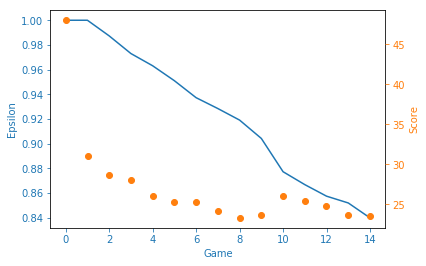

In [6]:
utils.plotLearning(np.arange(len(scores)), scores, eps_history, filename)

done = False
score=0
observation = env.reset()
while not done:
    env.render()
    action = agent.choose_action(observation)
    observation_, reward, done, info = env.step(action)
    score += reward

    agent.store_transition(observation, action, reward, observation_, done)
    agent.learn()
    observation = observation_
env.close()
print(f'Score is:{score}')

In [ ]:
def train_more(n_games=50, avg_to_break = 350):
    for i in range(n_games):
        score = 0
        done = False
        observation = env.reset()
        while not done:

            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_transition(observation, action, reward, observation_, done)
            agent.learn()
            observation = observation_
        scores.append(score)
        eps_history.append(agent.epsilon)
        avg_score = np.mean(scores[-10:])
        print('episode ', i, 'score %.2f' % score, 'average score %.2f' % avg_score, 'epsilon %.2f' % agent.epsilon)
        if avg_score > avg_to_break:
            return # same as break
    
train_more(n_games=30, avg_to_break = 350)

In [ ]:
import pickle
# pickle.dump(agent, open(f'agent_CartPole-v1_{len(scores)}.p', "wb" ))

# agent = pickle.load(open("agent_LunarLander-v2_400.p",'rb'))